#**Stabilization of Cart Pole system**: 
> Consider cart pole system:
>
>
><p><img alt="mbk" height="250px" src="https://drive.google.com/uc?id=1O1iM6MByfMyrO0txAMFb_miOqPNzFAvm" align="center" hspace="350px" vspace="0px"></p>
>
>
> Do the following:
>*   1) Design the linear feedback controller using linearization of the cart-pole dynamics.
>*   2) Simulate the response of your controller on the linearized and nonlinear system, compare the results.
>*   3) Taking into account that $y = Cx$ is measured, design observer and linear control that uses observer state. 
>*   4) Simulate the nonlinear system with the observer and controller, show the difference between the actual motion of the nonlinear system and its estimate produced by teh observer.
>
> [Here is the great illustration of the hardware implemintation of the cart-pole](https://www.youtube.com/shorts/NJxBJ2LJY7w) 


##**System Dynamics**: 

Recall the dynamics of cart-pole system:
\begin{equation}
\begin{cases} 
\left(M+m\right){\ddot {p}}-m L \ddot{\theta} \cos \theta +m L \dot{\theta }^{2}\sin \theta = u \\
L \ddot{\theta}- g\sin \theta =\ddot{p} \cos \theta  \\
\end{cases}
\end{equation}

where $\theta$ is angle of the pendulum measured from the upper equilibrium and $p$ is position of cart


Choosing the state to be $\mathbf{x} = [\theta, \dot{\theta}, p, \dot{p}]^T$One may rewrite this dynamics in the state-space form as:
\begin{equation}
\mathbf{\dot{x}} = 
\begin{bmatrix}
\dot{\theta} \\ 
\ddot{\theta} \\ 
\dot{p} \\ 
\ddot{p}
\end{bmatrix} 
= 
\begin{bmatrix}
\dot{\theta} \\ 
\frac{(M+m)g \sin \theta - mL \dot{\theta}^2 \sin\theta \cos\theta}{(M + m\sin^2 \theta)L} \\ 
\dot{x} \\ 
\frac{mg\sin\theta \cos\theta - mL\dot{\theta}^2 \sin \theta}{M + m\sin^2 \theta} \\ 
\end{bmatrix} 
+
\begin{bmatrix}
0 \\ 
\frac{\cos\theta}{(M + m\sin^2 \theta)L} \\ 
0 \\ 
\frac{1}{M + m\sin^2 \theta} \\ 
\end{bmatrix} u
\end{equation}


###**System parameters**: 
Let us choose the following parameters:

In [ ]:
m = 0.5 # mass of pendulum bob
M = 2 # mass of cart
pendulumn_length = 0.3 # length of pendulum
g = 9.81 # gravitational acceleration 


####**Nonlinear dynamics**: 

First of all let us define the nonlinear system in form $\dot{\mathbf{x}} = \mathbf{f}(\mathbf{x}, \mathbf{u})$ :

In [ ]:
import numpy as np
from math import cos, sin

import matplotlib.pyplot as plt

# sin, cos = np.sin, np.cos
# Nnonlinear cart-pole dynamics
def f(x, u):
    theta, dtheta, p, dp = x
    u = u[0]

    denominator = M + m*(sin(theta)**2)
    ddtheta = ((M + m)*g*sin(theta) - m* pendulumn_length * dtheta**2 *sin(theta) * cos(theta) + cos(theta)*u)/(denominator * pendulumn_length)
    ddp = (m*g*sin(theta)*cos(theta) - m* pendulumn_length * dtheta**2 *sin(theta) + u)/denominator

    dx = np.array([dtheta, ddtheta, dp, ddp])
    return dx

x0 = np.array([1, # Initial pendulum angle
      0, # Initial pendulum angular speed
      1, # Initial cart position
      0]) # Initial cart speed
u0 = np.array([0])
print(f(x0, u0))

[ 0.         29.22225161  0.          0.947331  ]


###**Linearized Dynamics**: 

Liniarization around the upper equilibrium $\mathbf{x} = [0,0,0,0]$ yields:

\begin{equation}
\mathbf{\dot{x}} = 
\begin{bmatrix}
\dot{\theta} \\ 
\ddot{\theta} \\ 
\dot{p} \\ 
\ddot{p}
\end{bmatrix} 
=
\begin{bmatrix}
0 & 1 & 0 & 0\\
\frac{(M+m)}{M}\frac{g}{L} & 0 & 0 & 0 \\
0 & 0 & 0 & 1 \\
\frac{m}{M}g & 0 & 0 & 0 
\end{bmatrix} 
\begin{bmatrix}
\theta \\ 
\dot{\theta} \\ 
p \\ 
\dot{p}
\end{bmatrix} 
+
\begin{bmatrix}
0 \\
\frac{1}{ML} \\
0 \\
\frac{1}{M}
\end{bmatrix}
u
\end{equation}

In [ ]:
# System matrix
A = np.array([[0, 1, 0, 0],
             [(M + m)*g /(M*pendulumn_length), 0, 0, 0],
             [0,0,0,1],
             [m*g/M, 0, 0, 0]])
# Input matrix
B = np.array([[0],
             [1/(M*pendulumn_length)],
             [0], 
             [1/M]])
C = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0]])

###**Controller Design**: 

Let us design the controller for linearized plant by placing poles (eigen values) on the left-hand side of complex plane:


In [ ]:
from scipy.signal import place_poles

A_obs = A
controlPoles = [-1, -1.5, -2, -1.1]
observerPoles = [-1, -1.5, -2, -4]


K_pp = place_poles(A, B, controlPoles)
K_PP_gain = K_pp.gain_matrix
K = K_PP_gain
print("Pole placement with full information avalible yields K =", K_PP_gain[0])
print("With eigenvalues of (A-BK) =", (np.linalg.eig(A-np.dot(B, K_PP_gain)))[0])
print(f"u = -{K_PP_gain[0]}x\n")

L_pp = place_poles(A.T, C.T, observerPoles)
L = L_pp.gain_matrix.T
# print(L)
print("Pole placement on Observer yields L =", L)
print("With eigenvalues of (A-LC) =", (np.linalg.eig(A-np.dot(L, C)))[0])
observer_params = {'A':A_obs,'C':C, 'L':L}

Pole placement with full information avalible yields K = [31.45555046  3.54623853 -0.20183486 -0.62079511]
With eigenvalues of (A-BK) = [-2.  -1.5 -1.1 -1. ]
u = -[31.45555046  3.54623853 -0.20183486 -0.62079511]x

Pole placement on Observer yields L = [[ 1.79069961e+00  1.24666482e+00  2.98796926e-04]
 [ 4.11216648e+01  1.70930045e+00 -3.16382022e-04]
 [ 6.69992655e-04 -6.34656177e-04  4.99999994e+00]
 [ 2.45336919e+00 -8.45577581e-04  4.00000019e+00]]
With eigenvalues of (A-LC) = [-4.  -2.  -1.5 -1. ]


Insert your control design / observer design code here.

Check eigenvalues of the closed-loop system for 1) closed-loop for the case when full state information is availible and no observer is used, 2) when only measurement y = C*x is availible and an observer is used.

##**Simulation**:
We proceed with the simulation of designed controller, firstly we will define the simulation parameters: 

In [ ]:
# Time settings
t0 = 0 # Initial time 
tf = 10 # Final time
N = 1000 # Numbers of points in time span
t = np.linspace(t0, tf, N) # Create time span

# Define initial point 
theta_0 = 0.4
p_0 = 0.1

# Set initial state 
x0 = np.array([theta_0, # Initial pendulum angle
      0, # Initial pendulum angular speed
      p_0, # Initial cart position
      0]) # Initial cart speed


####**Linearized dynamics**: 
Now let us simulate the response of linear controller on the **linearized** system:

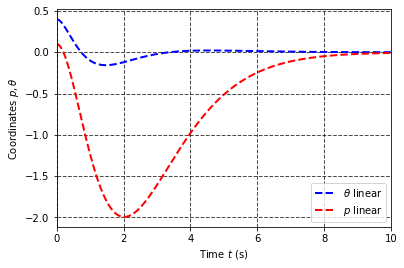

In [ ]:
# import integrator routine
from scipy.integrate import odeint 

# Define the linear ODE to solve
def linear_ode(x, t, A, B, K):
    # Linear controller
    u = - np.dot(K,x)  
    # Linearized dynamics
    dx = np.dot(A,x) + np.dot(B,u)
    return dx

# integrate system "sys_ode" from initial state $x0$
x_l = odeint(linear_ode, x0, t, args=(A, B, K,)) 
theta_l, dtheta_l, p_l, dp_l = x_l[:,0], x_l[:,1], x_l[:,2], x_l[:,3] 
# Plot the resulst
plt.plot(t, theta_l, 'b--', linewidth=2.0, label = r'$\theta$ linear')
plt.plot(t, p_l, 'r--', linewidth=2.0, label = r'$p$ linear')
plt.grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
plt.grid(True)
plt.legend()
plt.xlim([t0, tf])
plt.ylabel(r'Coordinates $p,\theta$')
plt.xlabel(r'Time $t$ (s)')
plt.show()

Now we will simulate similarly to linear case while using the same gains $\mathbf{K}$:

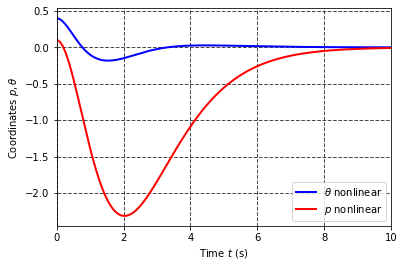

In [ ]:
def nonliear_ode(x, t, K):

    # Linear controller
    u = - np.dot(K,x)  

    # Nonlinear dynamics
    dx = f(x, u)

    return dx

# integrate system "sys_ode" from initial state $x0$
x_nl = odeint(nonliear_ode, x0, t, args=(K,)) 
theta_nl, dtheta_nl, p_nl, dp_nl = x_nl[:,0], x_nl[:,1], x_nl[:,2], x_nl[:,3] 
# Plot the resulst
plt.plot(t, theta_nl, 'b', linewidth=2.0, label = r'$\theta$ nonlinear')
plt.plot(t, p_nl, 'r', linewidth=2.0, label = r'$p$ nonlinear')
plt.grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
plt.grid(True)
plt.legend()
plt.xlim([t0, tf])
plt.ylabel(r'Coordinates $p,\theta$')
plt.xlabel(r'Time $t$ (s)')
plt.show()

### Simulation with observer

Insert your code simulating the behaviour of the nonlinear system with an observer. Plot the results, compare state estimatio and actual state of the system.

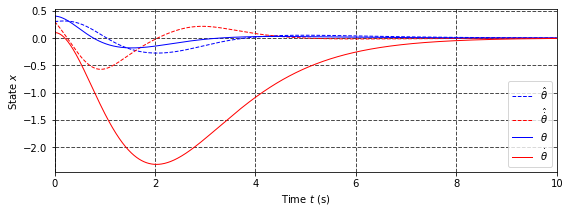

In [ ]:
def observer_ode(state, t, system_param, observer_params):
  x, x_hat = np.split(state, 2)
  A = system_param['A']
  B = system_param['B']
  C = observer_params['C']
  L = observer_params['L']
  A_obs = observer_params['A']

  u = -K @ x_hat
  e = C @ x - C @ x_hat
  dx = f(x, u)
  dx_hat = f(x_hat, u) + L @ e

  dstate = np.hstack((dx, dx_hat))
  return dstate


system_params = {'A':A, 'B':B}
observer_params = {'A':A, 'C':C, 'L':L}

x0_hat = x0 + [-0.1, 0.3, 0.1, -0.1]
state_0 = np.hstack((x0, x0_hat))
state_sol = odeint(observer_ode, state_0, t, args=(system_params, observer_params)) # integrate system "sys_ode" from initial state $x0$

x_real, x_hat = np.split(state_sol, 2, axis = 1)
theta, dtheta, x, dx = np.split(x_real, 4, axis = 1)
theta_hat, dtheta_hat, x_hat, dx_hat = np.split(x_hat, 4, axis = 1)

plt.figure(figsize=(9, 3))
plt.plot(t, theta_hat, 'b--', linewidth=1.0, label=r'$\hat{\theta}$')
plt.plot(t, dtheta_hat, 'r--', linewidth=1.0, label=r'$\hat{\dot{\theta}}$')
plt.plot(t, theta_nl, 'b', linewidth=1.0, label = r'$\theta$')
plt.plot(t, p_nl, 'r', linewidth=1.0, label = r'$\dot{\theta}$')
plt.legend()
plt.grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
plt.grid(True)
plt.xlim([t0, tf])
plt.ylabel(r'State ${x}$')
plt.xlabel(r'Time $t$ (s)')
plt.show()


###**Comparison**: 
One may compare the linear and nonlinear responses by plotting them together:

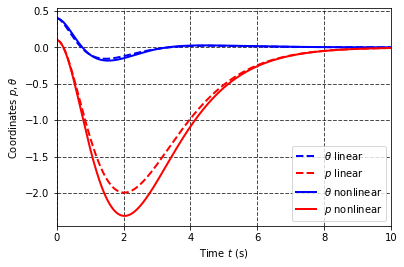

In [ ]:
# theta_l, p_l - values of theta and p for the linear system
# theta_nl, p_nl - values of theta and p for the nonlinear system

plt.plot(t, theta_l, 'b--', linewidth=2.0, label = r'$\theta$ linear')
plt.plot(t, p_l, 'r--', linewidth=2.0, label = r'$p$ linear')
plt.plot(t, theta_nl, 'b', linewidth=2.0, label = r'$\theta$ nonlinear')
plt.plot(t, p_nl, 'r', linewidth=2.0, label = r'$p$ nonlinear')
plt.grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
plt.grid(True)
plt.legend()
plt.xlim([t0, tf])
plt.ylabel(r'Coordinates $p,\theta$')
plt.xlabel(r'Time $t$ (s)')
plt.show()

# Animation

In [ ]:
p = p_nl
theta = theta_nl
time = t

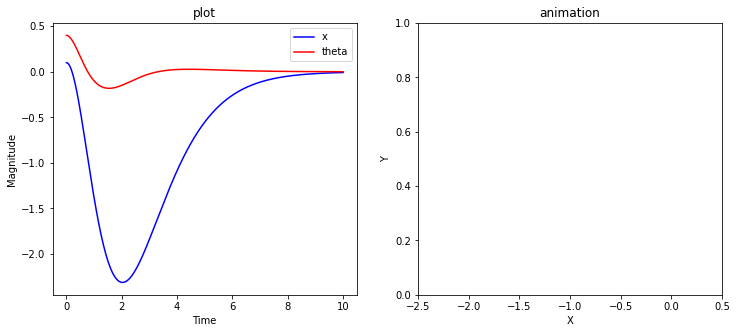

In [ ]:
%matplotlib inline

# create a figure and axes
fig = plt.figure(figsize=(12,5))
ax1 = plt.subplot(1,2,1)   
ax2 = plt.subplot(1,2,2)

# set up the subplots as needed
# ax1.set_xlim(( 0, 2))            
# ax1.set_ylim((-0.3, 0.3))
ax1.set_xlabel('Time')
ax1.set_ylabel('Magnitude')

ax2.set_xlim((-2.5,0.5))
ax2.set_ylim((0,1))
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_title('animation')

# create objects that will change in the animation. These are
# initially empty, and will be given new values for each frame
# in the animation.
txt_title = ax1.set_title('plot')
line_x,     = ax1.plot(time, p, 'b')     # ax.plot returns a list of 2D line objects
line_theta, = ax1.plot(time, theta, 'r')
point_x,     = ax1.plot([], [], 'g.', ms=20)
point_theta, = ax1.plot([], [], 'g.', ms=20)

draw_cart,  = ax2.plot([], [], 'b', lw=2)
draw_shaft, = ax2.plot([], [], 'r', lw=2)

ax1.legend(['x','theta']);

In [ ]:
shaft_l = 0.3
cart_l = 0.1
cart_x = np.array([-1, -1, 1, 1, -1])*cart_l
cart_y = np.array([ 0,  1, 1, 0,  0])*cart_l


# animation function. This is called sequentially
def drawframe(n):

    shaft_x = np.array([ p[n],  p[n] - shaft_l*sin(theta[n] )]) # Changed the sign of the second part to '-' for animation to represent correct position of the pendulum 
    shaft_y = np.array([ cart_l/2,  cart_l/2 + shaft_l*cos(theta[n] )])

    line_x.set_data(time, p)
    line_theta.set_data(time, theta)

    point_x.set_data(time[n], p[n])
    point_theta.set_data(time[n], theta[n])

    draw_cart.set_data(cart_x+p[n], cart_y)
    draw_shaft.set_data(shaft_x, shaft_y)
    
    txt_title.set_text('Frame = {0:4d}'.format(n))
    return (draw_cart,draw_shaft)

In [ ]:
from matplotlib import animation

# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=800, interval=20, blit=True)

## Here we try to make a video of the cart-pole as it moves

In [ ]:
from IPython.display import HTML
HTML(anim.to_html5_video())